# Load libraries

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    %pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

# Read train and test data

In [4]:
dfXtrain = pd.read_csv('X.train.csv')
dfXtest = pd.read_csv('X.test.csv')
dfYtrain = pd.read_csv('y.train.csv')
Xtrain = np.array(dfXtrain)
Xtest = np.array(dfXtest)

ytrain = np.array(dfYtrain['label'])

In [5]:
print('Data size:', dfXtrain.shape)
dfXtrain.head()

Data size: (4099, 1330)


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826,0,0,0,0,0,0,NaN,NaN,0,...,0.0,0.0,0,0.0,1.0,1,0.0,NaN,0.0,0.5
1,15,0,0,0,0,0,0,0.030303,0.083333,0,...,0.0,0.0,1,0.0,0.0,0,0.5,0,0.5,0.0
2,242,0,0,0,0,0,0,NaN,NaN,0,...,1.0,1.0,0,0.5,0.0,0,1.0,0,0.0,0.5
3,1038,0,0,0,0,0,0,NaN,NaN,0,...,0.5,0.5,0,0.0,0.0,0,0.0,0,0.0,0.5
4,971,0,0,0,0,0,0,NaN,NaN,0,...,0.0,0.0,1,0.0,0.5,0,0.0,0,0.0,0.0


# Replace all NaN's in train and test data to most frequent values in train data

In [6]:
Xbig = np.vstack((Xtrain, Xtest))

In [7]:
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp.fit(Xbig)

Xtrain = imp.transform(Xtrain)
Xtest = imp.transform(Xtest)

# Train Random Forest classifier

In [8]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xtrain, ytrain, test_size=0.5)

In [9]:
from sklearn.metrics import log_loss

In [10]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(log_loss(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [11]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('LL')
    legend()

1.71937529026
0.0549570983773
0.0547685994845
0.0548446140935
0.0546815226363
0.0546449523414
0.0545145962177
0.0544671591684
0.0543776144523
0.0544541962401
4.00991567438
0.247135738393
0.215703630767
0.215540742297
0.215496752921
0.215041600531
0.214913966608
0.214795868871
0.21453084507
0.21424291461


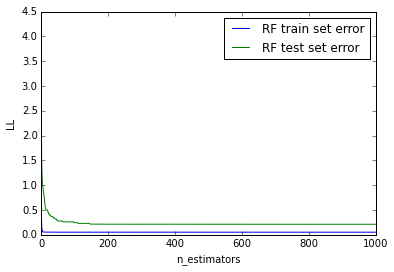

In [34]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=330, n_jobs=-1),
               X_train[:, :330], X_test[:, :330], y_train, y_test,
               prefix='RF')

In [13]:
from sklearn.grid_search import GridSearchCV

In [35]:
clf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features=330, n_jobs=-1)
clf.fit(Xtrain[:, :330], ytrain)

ypred = clf.predict_proba(Xtest[:, :330])[:, 1]

Попробуем разобраться с генетической информацией

In [65]:
from numpy.linalg import svd

In [70]:
from sklearn.preprocessing import scale
X_gene = scale(Xtrain, with_mean = True, with_std=False, axis=0)

In [75]:
U, s, V = svd(X_gene, False)

In [76]:
U.shape, V.shape, s.shape

((4099, 1330), (1330, 1330), (1330,))

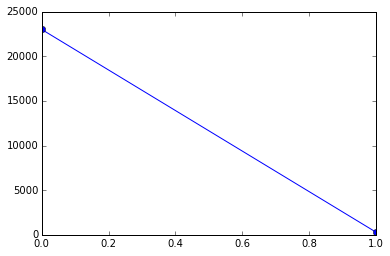

In [85]:
plot(s[0:2], '-o')

Новый нулевой признак -- нормальный такой обычный человек. А вот все остальные признаки могут дать отклонения от нормальности, в том числе и болезни.

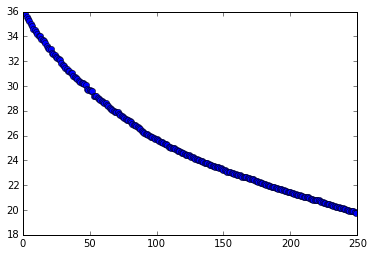

In [93]:
plot(s[50:300], '-o')

In [99]:
from sklearn.linear_model import LogisticRegression as LR

In [112]:
def learn(clf, params):
    grid_searcher = GridSearchCV(clf,\
                             params, cv=5, scoring='log_loss', n_jobs=-1)
    grid_searcher.fit(U, ytrain)

    print(grid_searcher.best_score_)
    print(grid_searcher.best_estimator_)
    
    return grid_searcher

In [113]:
%%time

params = {'penalty': ['l1', 'l2'], 'C': [0.5, 1]}
lr_grid_searcher = learn(LR(), params)

-0.239570357319
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
CPU times: user 2.35 s, sys: 155 ms, total: 2.51 s
Wall time: 13.9 s


In [114]:
clf = lr_grid_searcher.best_estimator_
clf.fit(U, ytrain)

Utest = np.dot(np.dot(Xtest, V.T), np.diag(pow(s, -1)))

ypred = clf.predict_proba(Utest)[:, 1]

In [105]:
X_train_gene, X_test_gene, y_train_gene, y_test_gene = cross_validation.train_test_split(U[:, 1:50], ytrain, test_size=0.5)

1.60138044655
0.0553729134173
0.0554767169179
0.055849515541
0.0560440951844
0.0560788020576
0.0560634220024
0.0559352348427
0.0559605878186
0.0559866107868
4.97026994094
0.307300478779
0.271432196373
0.27187034945
0.271077203662
0.271046374391
0.271273732645
0.271457256285
0.271083618734
0.270435478125


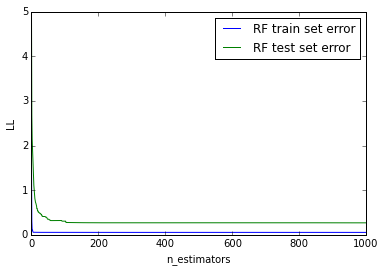

In [89]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=None, n_jobs=-1),
               X_train_gene, X_test_gene, y_train_gene, y_test_gene,
               prefix='RF')

# Save predictions

In [115]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y.predicted.csv', index = False)